In [8]:
#pip install imutils

In [22]:
#pip install opencv-python

In [36]:
#pip install tensorflow

In [21]:
#veriyi okuma ve işleme adımmında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

In [22]:
#warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings('ignore')

In [23]:
#Model degerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

In [24]:
#Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [25]:
target_size=(224, 224),
waste_labels = {'cardboard' : 0 , 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash' : 5}

In [26]:
def load_datasets(path):
    """
    Görsellerin bulunduğu diizndeki görüntüyü okuyup etiketlerini oluşturur
    Parametreler:
    path: Görsellerim bulunduğu dizini ifade eder.
    Return:
    x: Görüntülere ait matris bilgilerini tutar.
    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste
    """
    x = []
    labels = []

    # gönderdiğimiz pathdeki görüntüleri listleyip sıralamaktadır.
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        #belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
        img = cv2.imread(image_path)

        #okunan görüntüler baslangıcta belirlenen target_size a göre yeniden ölceklendirebilir.
        img = cv2.resize(img,target_size)

        #ölceklendirilen görüntüler x listesine eklenir.
        x.append(img)

        #her bir path '/' ifadesi ile ayrıldıgında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
        label = image_path.split(os.path.sep)[-2]

        #yakalanan labelların sayısal deger karsılıklarının olduğu waste_labels sözlügü içerisinden 
        #gönderilen key degerine karsılık value degeri alınarak label olusuturulur.
        labels.append(waste_labels[label])

    #veri seti random bir sekilde karısıtırılır.
    x, labels = shuffle(x,labels,random_state=42)

    #boyut ve sınıf bilgisi raporlanmaktadır.
    print(f"X boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

    return x, labels
    

In [27]:
dir_path = r"C:\Users\glylm\Desktop\trkcl\Garbage_classification\Garbageclassification"  # Veri kümesinin bulunduğu dizinin yolunu belirtin
target_size = (224,224)
x, labels = load_datasets(dir_path)

X boyutu: (5051, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 5051


In [28]:
#görüntü boyutlrının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


### veri setindeki örnekler gösterilmesi


In [29]:
def visualize_img(image_batch, label_batch):
    """
    Veri seti içerisindeki görüntü görsellestiriilir
    paarametreler:
    image_batch: görüntülere ait matris bilgilerini tutuar.
    label_batch: görüntünün  ait olduğu sınıf bilgisini  tutan liste
    
    """
    plt.figure(figsize = (10,10))
    for n in range(10):

        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
        plt.axis('off')
        

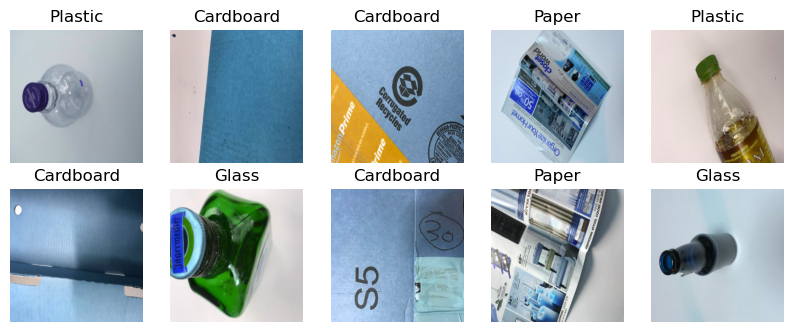

In [30]:
visualize_img(x,labels)

### veriyi hazırlamak

In [31]:
# Train veri seti için bir generator tanımlıyoruz.
train = ImageDataGenerator(horizontal_flip= True, #görüntüleri rastgele yatay cevirir
                          vertical_flip= True, #rastgele dikey ceviriri
                           validation_split = 0.1, #test veri seti oranı
                           rescale = 1./255, # yeniden ölceklendirme
                           shear_range = 0.1, # görüntüye egim verir
                           zoom_range = 0.1, #genişlik kaydırma
                           width_shift_range = 0.1,
                           height_shift_range= 0.1
                          )
# Test veri seti için bir generator tanımlıyoruz
test = ImageDataGenerator(rescale = 1/255,
                          validation_split= 0.1)

In [32]:
#flow_from_directory = fonksiyonuyla tensorflow ortamında görüntüleri okumak için kullanıyoruz
train_generator = train.flow_from_directory(directory = dir_path, #görüntülerin bulundugu dizin bilgisi
                                      target_size = (target_size), #bulunan görüntüleri ölceklendirmekiçin
                                      batch_size=251, # veri gruplarının boyutunu
                                      class_mode ='categorical',
                                      subset ='training')

test_generator = test.flow_from_directory(directory = dir_path,
                                      target_size = (target_size),
                                      batch_size=251,
                                      class_mode ='categorical',
                                      subset ='validation')

Found 4548 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


## Modelleme ( modeling)
* sequential
* Evrişim Katmanı(Convolution Layer,Conv2D)
* Havuzlama Katmanı(Pooling Layer)
* Aktivasyon Fonksiyonu Katmanı(Activation layer)
* Flattening Katmanı
* Dense katmanı
* Dropout Katmanı

In [33]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
# 1.katman  sequential sıralı katman
model = keras.Sequential()
# 2.katman evrisim katmanı(algılama kısmı
model.add(Conv2D(filters=32, # görüntü üzerindeki filtre sayısı
                 kernel_size=(3,3), #gezdirelecek olan filtre sayısı
                 padding = 'same', # evrisim katmanı sonraası pixel ekleme yapılarak giris vecıksı boyut farkı ortadan kaldırılır
                 input_shape = (input_shape), # giris bilgilerinin boyut bilgisini ifade etmektedir
                 activation ='relu')) # act fonksiyonumuz
# 3.katman pooling (havuzlama) ve 4.katman activasyon kısmı burada
model.add(MaxPooling2D( #sadece boyut azaltmak için kullanılır evrisim katmanından sonra
    pool_size = 2, #görüntü üzerinde gezdirilecek boyut bilgisi
     strides=(2,2)))
#2. ve 3.katman 3 kere
model.add(Conv2D(filters=64, # görüntü üzerindeki filtre sayısı
                 kernel_size=(3,3), #gezdirelecek olan filtre sayısı
                 padding = 'same', # evrisim katmanı sonraası pixel ekleme yapılarak giris vecıksı boyut farkı ortadan kaldırılır
                 input_shape = (input_shape), # giris bilgilerinin boyut bilgisini ifade etmektedir
                 activation ='relu')) # act fonksiyonumuz
# 3.katman pooling (havuzlama) ve 4.katman activasyon kısmı burada
model.add(MaxPooling2D( #sadece boyut azaltmak için kullanılır evrisim katmanından sonra
    pool_size = 2, #görüntü üzerinde gezdirilecek boyut bilgisi
     strides=(2,2)))
model.add(Conv2D(filters=32, # görüntü üzerindeki filtre sayısı
                 kernel_size=(3,3), #gezdirelecek olan filtre sayısı
                 padding = 'same', # evrisim katmanı sonraası pixel ekleme yapılarak giris vecıksı boyut farkı ortadan kaldırılır
                 input_shape = (input_shape), # giris bilgilerinin boyut bilgisini ifade etmektedir
                 activation ='relu')) # act fonksiyonumuz
model.add(MaxPooling2D( #sadece boyut azaltmak için kullanılır evrisim katmanından sonra
    pool_size = 2, #görüntü üzerinde gezdirilecek boyut bilgisi
     strides=(2,2)))
# 5.katman Flatenning katmanı(tek boyutlu diziye cevirir)
model.add(Flatten())
#6.katman(dense)(nöronları=units diğer katmana girdi olarak katar) ve 
#7.katman dropout(asırır ogrenmenin önüne gecmek için kullanılır)
model.add(Dense(units = 64, activation ='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=6, activation='softmax')) # 6 sınıflı 

In [34]:
#model özeti
model.summary()
#layer(type) = katmnaların isimleri
#output shape = cıktıların boyut bilgisi(32 filtre sayısı

#ögrenilecek olan parametre sayısı  896
#

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

### Optimizasyon ve değerlendirme metriklerinin ayarlanması

In [35]:
model.compile(loss = 'categorical_crossentropy',
             # Modelin hata fonksiyonunu (loss function) çok sınıflı sınıflandırma için
              #categorical crossentropy olarak ayarlar.
              optimizer = 'adam',
    # Modelin optimizasyon algoritmasını adam olarak ayarlar.
              metrics= [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])
# Modelin performansını ölçmek için kesinlik (precision),
#geri çağırma (recall) ve doğruluk (accuracy) metriklerini kullanır.


In [36]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience= 50, verbose=1, mode= "min"),
             # Doğrulama kaybı (val_loss) izlenir, 50 epok boyunca iyileşme olmazsa eğitim durdurulur, 
             #durdurma mesajı yazdırılır 
             #ve minimum val_loss aranır.
             ModelCheckpoint(filepath = 'mymodel.keras', monitor = 'val_loss', mode ='min',
                             # En iyi val_loss'a sahip model mymodel.h5 dosyasına kaydedilir, 
                             #tüm model (ağırlıklar ve mimari) kaydedilir 
                             #ve kaydetme mesajı yazdırılır.
                             save_best_only= True,
                             #Sadece en iyi doğrulama kaybına sahip olan modeli kaydeder.
                             #Bu, en iyi performansa sahip modelin saklanmasını sağlar.
                             save_weights_only = False,
                             #Modelin tüm yapısını (ağırlıklar ve mimari) kaydeder.
                             #Eğer True olsaydı sadece ağırlıklar kaydedilirdi.
                             verbose=1)] 
                            #Model kaydedildiğinde bir mesaj yazdırır.
             

### Modelin Eğitilmesi

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    steps_per_epoch=2276//32,
                    validation_steps=251//32)
# Model Kaydetme (doğru format)
model.save('mymodel.keras')


Epoch 1/100
19/71 ━━━━━━━━━━━━━━━━━━━━ 3:46 4s/step - acc: 0.2098 - loss: 1.7827 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 1: val_loss improved from inf to 1.67963, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - acc: 0.2231 - loss: 1.7616 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_acc: 0.2525 - val_loss: 1.6796 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/100
19/71 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - acc: 0.2897 - loss: 1.6702 - precision_1: 0.6350 - recall_1: 0.0102
Epoch 2: val_loss improved from 1.67963 to 1.48203, saving model to mymodel.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - acc: 0.3065 - loss: 1.6407 - precision_1: 0.7183 - recall_1: 0.0272 - val_acc: 0.3936 - val_loss: 1.4820 - val_precision_1: 0.8235 - val_recall_1: 0.1113
Epoch 3/100
19/71 ━━━━━━━━━━━━━━━━━━━━ 3:10 4s/step - acc: 0.3913 - loss: 1.5110 - precision_1: 0.7422 - recall_1: 0.1094
Epoch 3: val_loss improved from 1.48203 to 1.41532, saving m

### Accuracy ve Loss grafikleri 

In [ ]:
import os

dir_path = r"C:/Users/glylm/Desktop/Garbage_classification/Garbage classification"
for folder in os.listdir(dir_path):
    class_dir = os.path.join(dir_path, folder)
    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        if not os.path.isfile(fpath):
            print(f"Missing: {fpath}")

In [ ]:
# ACCURACY GRAFİĞİ
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label = 'Traning Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy' ,fontsize= 16)
plt.ylim(min(plt.ylim()),1])
plt.title('Traning and Validation Accuracy', fontsize=16)


In [ ]:
# LOSS GRAFİĞİ
plt.figure(figsize= (20,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = 'Traning Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss' ,fontsize= 16)
plt.ylim([0,max(plt.ylim())])
plt.title('Traning and Validation Loss', fontsize=16)


### Değerlendirme(Evaluation)

In [ ]:
loss, precision,recall,acc = model.evaluate(test_generator, batch_size= 32)

In [ ]:
print("\nTest accuracy: %.lf%%" %(100.0 * acc))
print("\nTest loss: %.lf%%" %(100.0 * loss))
print("\nTest precision: %.lf%%" %(100.0 * precision))
print("\nTest recall: %.lf%%" %(100.0 * recall))


In [ ]:
# Classification REPORT
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
target_names = list(waste_labels.keys())

In [ ]:
print(classification_report(y_test, y_pred,target_names = target_names))

#### Confusion matrix (ek detay)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm,classes,
                          normalize= False,
                          title= 'Confusion matrix',
                          cmap= plt.cm.Blues):
    """
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize =(8,6))
plt.imshow(cm, interpoltion= 'nearest', cmap = cmap)
plt.title(title)
pltt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j], fmt),
             horizontlaligment = "center",
             color = "white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label' , fontweight = "bold")
    plt.xlabel('Predicted label', fontweight = "bold")
             

In [ ]:
plot_confusion_matrx(cm, waste_labels.keys(),
                     title = 'Confusion matrix',
                     cmap = plt.cm.OrRd)

### Modelin Kullanılması/Test edilmesi

In [ ]:
waste_labels = {0: 'cardboard', 1: 'glasses', 2:'metal', 3: 'paper',4: 'plastic', 5:'trash'}

In [ ]:
def model_testing(path):
    '''
    Görsellerin bulunduğu dizindeki görüntüyü okuyup model aracılıgı ile hangi sınıfa ait olduguna 
    dair tahmin işlemi gerceklestirilir.
    Parametreler:
    path: Görsellerin bulunduğu dizini ifade eder.
    Return:
    img: Görüntü
    p: Tahmin olasılıkları
    predicted_class: Tahmin sınıfı
    '''
    img = image.load_img(path,target_size = (target_size))
    img=image.img_to_array(img, dtype= np.uint8)
    img =np.array(img)/255.0
    p=model.predict(img.reshape(1,224,224,3))
    predicted_class = np.argmax(p[0])
    
    return img,p, predicted_class


img1,p1, predicted_classes1 = model_testing('')
img2,p2, predicted_classes2 = model_testing('')
img3,p3, predicted_classes3 = model_testing('')
img4,p4, predicted_classes4 = model_testing('')

In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis= -1)) + "/n" + "Predicted class:" + str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis= -1)) + "/n" + "Predicted class:" + str(waste_labels[predicted_class2]))
plt.imshow(img1);
